<a href="https://colab.research.google.com/github/tr3nt-tayl0r/CIMIS/blob/main/colabs/graphs/Mean_temp_correction_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/tr3nt-tayl0r/CIMIS.git

Cloning into 'CIMIS'...
remote: Enumerating objects: 10896, done.
remote: Counting objects: 100% (435/435), done.
remote: Compressing objects: 100% (401/401), done.
remote: Total 10896 (delta 50), reused 396 (delta 34), pack-reused 10461 (from 1)
Receiving objects: 100% (10896/10896), 662.64 MiB | 8.39 MiB/s, done.
Resolving deltas: 100% (2229/2229), done.
Updating files: 100% (4037/4037), done.


In [ ]:
import glob
import os
import sys
import datetime
import numpy as np
import pandas as pd
import json
import requests
import datetime
import matplotlib.pyplot as plt
from google.colab import userdata
!pip install cartopy
import cartopy
import geopandas as gpd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 54.1 MB/s eta 0:00:00


In [ ]:
station_ids = [2, 6, 7, 12, 13, 15, 35, 39, 41, 43, 44, 47, 52, 64, 68, 70, 71, 75, 77, 78, 80, 83, 84, 87, 90, 91, 99, 104, 105, 106, 107, 113, 114, 117, 124, 125, 126, 129, 131, 140, 144, 146, 147, 150, 151, 152, 153, 157, 158, 160, 163, 165, 170, 171, 173, 174, 175, 178, 179, 181, 182, 184, 187, 191, 192, 193, 194, 195, 197, 199, 200, 202, 204, 206, 207, 208, 209, 210, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 225, 226, 227, 228, 229, 235, 236, 237, 240, 241, 242, 243, 244, 245, 247, 248, 249, 250, 251, 252, 253, 254, 256, 258, 259, 260, 261, 262, 264, 265, 266, 267, 268]

for id in station_ids:
  file = f'/content/CIMIS/CIMIS_Project_Data/CIMIS_daily_corr_data/station_id{id}_cimis_daily_corr.csv'
  df = pd.read_csv(file)
  df.set_index(pd.to_datetime(df.Date, format='mixed'), inplace=True)
  last_day = df.resample('M').last()
  last_day.set_index(pd.to_datetime(last_day.Date, format='mixed'), inplace=True)
  first_day = df.resample('M').first()
  first_day.set_index(pd.to_datetime(first_day.Date, format='mixed'), inplace=True)
  out_df = pd.DataFrame()
  for i in range(last_day.index.size):
    filtered_df = df.loc[first_day.index[i]:last_day.index[i]]
    filtered_df.loc[:,'Tdew_diff_avg'] = last_day.iloc[i]['Tdew_diff_avg']
    filtered_df.loc[:,'Tmax_diff_avg'] = last_day.iloc[i]['Tmax_diff_avg']
    filtered_df.loc[:,'Tmin_diff_avg'] = last_day.iloc[i]['Tmin_diff_avg']
    out_df = pd.concat([out_df, filtered_df])
  out_df.to_csv(file, index=False)

                               geometry  Station
Date                                            
2016-08-01  POINT (-120.11291 36.33622)        2
2016-08-01  POINT (-121.77636 38.53569)        6
2016-08-01  POINT (-120.59092 36.85122)        7
2016-08-01  POINT (-121.82443 39.60864)       12
2016-08-01  POINT (-120.73360 38.75314)       13
...                                 ...      ...
2016-08-01  POINT (-121.83528 39.38663)      244
2016-08-01  POINT (-117.58528 33.62167)      245
2016-08-01  POINT (-121.70125 38.03339)      247
2016-08-01  POINT (-121.39666 37.93207)      248
2016-08-01  POINT (-121.26615 37.75560)      249

[105 rows x 2 columns]


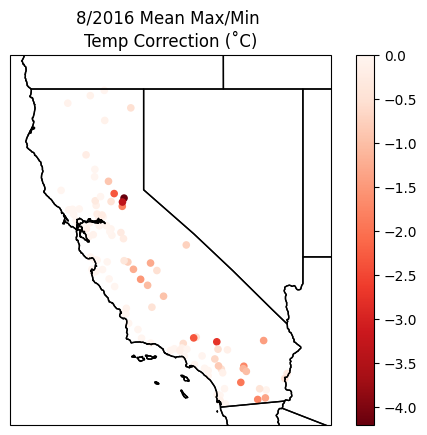

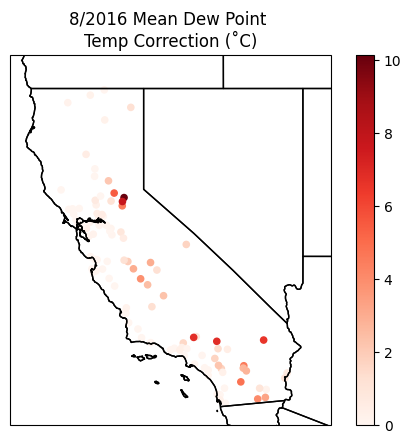

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point


def corr_mon_yr(df, month, year):
  df['Date'] = pd.to_datetime(df['Date'], format='mixed')
  df_my = df[(df['Date'].dt.month == month) & (df['Date'].dt.year == year)]
  df_my.set_index(pd.to_datetime(df_my.Date),inplace=True)
  return df_my


df = pd.read_csv('/content/CIMIS/stations/stations.csv')

month = 8
year = 2016
dir = '/content/CIMIS/CIMIS_Project_Data/CIMIS_daily_corr_data'

df_corr_my = pd.DataFrame()

for id in station_ids:
  file = f'{dir}/station_id{id}_cimis_daily_corr.csv'
  full_df = pd.read_csv(file)
  full_df.set_index(pd.to_datetime(full_df.Date, format='mixed'), inplace=True)

  df_my = corr_mon_yr(full_df, month, year)
  df_my = df_my[df_my['Date'] == f'{year}-{month}-01']
  df_corr_my = pd.concat([df_corr_my, df_my])
  #df_corr_my = df_corr_my[df_corr_my['Date'] == f'{year}-{month}-01']

# Create a list of shapely Point objects from the latitude and longitude columns
geometry = [Point(xy) for xy in zip(df_corr_my['Long'], df_corr_my['Lat'])]
# Create a GeoDataFrame from the DataFrame and the list of Points
geo_df = gpd.GeoDataFrame(df_corr_my, geometry=geometry)
# Set the coordinate reference system (CRS) for the GeoDataFrame
geo_df.set_crs(epsg=4326, inplace=True)  # EPSG:4326 is WGS84 lat/lon

print(geo_df[['geometry','Station']])

# Set up the plot with Cartopy and Matplotlib
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-125, -113, 32, 43], crs=ccrs.PlateCarree())

# Add coastlines and borders
ax.coastlines(resolution='10m')
#ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES.with_scale('10m'))

geo_df['Tmax_diff_avg'] = geo_df['Tmax_diff_avg'] * -1
# Plot the points using GeoPandas
geo_df.plot(ax=ax,  markersize=20, transform=ccrs.PlateCarree(), column='Tmax_diff_avg', legend=True, cmap='Reds_r')

# Display the
plt.title(f"{month}/{year} Mean Max/Min \nTemp Correction (˚C)")
# plt.colorbar(label='Temperature (˚C)')

plt.show()
#-----dew point plot follows------------------------------------------------------
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-125, -113, 32, 43], crs=ccrs.PlateCarree())

# Add coastlines and borders
ax.coastlines(resolution='10m')
#ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES.with_scale('10m'))

geo_df['Tdew_diff_avg'] = geo_df['Tdew_diff_avg'] * -1
geo_df.plot(ax=ax,  markersize=20, transform=ccrs.PlateCarree(), column='Tdew_diff_avg', legend=True, cmap='Reds')

plt.title(f"{month}/{year} Mean Dew Point \nTemp Correction (˚C)")
# plt.colorbar(label='Temperature')

plt.show()
